# Homework # 1: Audio Digital Classification

In this homework you will master all the basic skills needed to work with audio classification. The goal is to implement a simple speech recognition system which can classify spoken digits. We will work with the [**AudioMNIST** ](https://arxiv.org/pdf/1807.03418.pdf) dataset (audio equivalent of the MNIST dataset).

To construct an audio classifier you will need to implement dataloading, data preprocessing, augmentation and design a neural network which works well with audio data. In this homework you will:
* Learn how to use `torchaudio` as a library for working with audio in conjunction with `torch`
* Experiment with different feature representations of the audio signal in practice
* Develop an audio classification model based on recurrent networks
* Test the trained model on real data (on your own voice)


### Task Structure
This homework is structured as follows:

* Voice Activity Detection (VAD): Here we will create a custom test-set using either your own voice or some pre-recorded data. You will implement a simple energy-based VAD system that you can partition your data into separate digits.
* Dataloading: Here the goal is to learn how to preprocess an audio dataset into a convenient format. Additionally, here you can also add data augmentation, which can improve the quality of your model.
* Deep Leaening: This is the meat of the exercize. Here you will implement a simple audio classification neural network and train it in on the AudioMNIST dataset. Points will be awarded based on the performance of your model.


### Grading criteria

```
[ ] (4 point)  Implement energy VAD for audio splitting
[ ] (2 point)  Implement data preprocessing
[ ] (3 point)  Implement batching
[ ] (6 points) Train classification model (> 95% accuracy on validation)
[ ] (6 points) Achieve good test-score on our side (> 95% accuracy on hidden sample)
[ ] (4 points) Answer questions
```

### Submitting results

The results of this task are two artifacts:
1. this Jupiter Notebook (`.ipynb`) with completed cells
2. checkpoint of the `model.path` model on the "best" iteration

Save the artifacts to a directory named `{your last name}_{your first name}_hw1` and pack them in `.zip` archive.

## *Final score will be computed as number of points multiplied by 0.08 in purpose to set upper bound for your grade as 2*!

# Setup

#### Dockerfile
```
FROM nvidia/cuda:10.1-devel-ubuntu18.04

RUN apt-get update && apt-get install -y sox python3.7-dev python3.7-distutils curl
RUN ln -s /usr/bin/python3.7 /usr/bin/python
RUN ln -s /usr/bin/pip3 /usr/bin/pip

RUN curl --silent --show-error --retry 5 https://bootstrap.pypa.io/get-pip.py | python3.7
# torch==1.7.1+cu101 if GPU exists
RUN pip install torch==1.7.1 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
RUN pip install numpy==1.17.5 matplotlib==3.3.3 tqdm==4.54.0 jupyter
```

#### Bulding docker image

```
docker build -t hw1 -f Dockerfile .
```

#### Running docker container

```
# nvidia-docker if GPU exists
docker run -it --rm \
    --user $(id -u ${USER}):$(id -g ${USER}) \
    -p 8888:8888 \
    --volume $(pwd):$(pwd) \
    --workdir $(pwd) --env HOME=$(pwd) \
    --name hw1 hw1:latest jupyter notebook --ip 0.0.0.0
```

### Installing libraries

We will work with `torch` version `1.7.1` (with the corresponding version of `touchaudio`).

While the installation is in progress, you can run your eyes through the [documentation](https://pytorch.org/audio/stable/transforms.html) to `torchaudio` – from this library, we will only need a few transforms, as well as audio loading functions.

In [3]:
# !sudo apt-get install -y sox libsox-dev libsox-fmt-all
# # !pip install git+git://github.com/pytorch/audio

In [4]:
# ! apt-get update && apt-get install -y sox python3.7-dev python3.7-distutils curl

### Obtaining AudioMNIST dataset
<!-- 0️⃣1️⃣2️⃣3️⃣4️⃣5️⃣6️⃣7️⃣8️⃣9️⃣ -->

To get the dataset, clone the repository (`~1Gb`) running the code below:

In [5]:
# ! git clone https://github.com/soerenab/AudioMNIST

In [1]:
import os

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import shutil

from typing import List, Tuple
from glob import glob

from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, Audio
%matplotlib inline

DIGIT_NAMES = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

In [2]:
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # or ':16:8'

Select GPU

If you run this Jupyter Notebook on a computer with a video card (**GPU**), you need to specify which card you want to work with, and you also need to make sure that `torch` sees it.

If you *really* want, you can do your homework without using a video card, but then the training will take long time.

**Tip**: if the video card is an exhausted resource (i.e. you have a usage quota, or you pay for usage), then it is better to **debug** training without the GPU: to make sure that the model does not crash with an error, and the loss decreases in the first iterations.

In [3]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

if torch.cuda.is_available():
    print('GPU found! 🎉')
    device = 'cuda'
else:
    print('Only CPU found! 💻')
    device = 'cpu'

GPU found! 🎉


# Audio Partitioning via Voice Activity Detection (4 point)

Here you will create a custom test set for this homework by recording and partitioning your own voice using Voice Activity Detection (VAD).

### Grading criteria - for **ASSESSORS**

```
[ ] (1 point)  Energy is correctly highlighted
[ ] (3 point)  Digits are clearly separated
```

### Prepare the set for testing

The data for training and validation of your digit classification model will be taken from the `AudioMNIST` dataset. But as you know, there is a risk of overfitting not only on training set, but also on validation set. Therefore, for the purity of the experiment, we will evaluate your model on real data - your own voice!

You can record your own (or someone else's) voice speaking out the numbers, so you will have a real mini-dataset for testing. You will need this data  - You will test your model on your **own** testing set. 👀

To record your voice, you can use web-sites like [this](https://voice-recorder-online.com) or you can do this via the command line (you need the `sox` utility):

```
rec recording.wav trim 0 10   # record a 10-second audio fragment
of play recording.wav         # listen to it
```

For best results, say all the digit clearly at least ten times. Eg `[0, 1, 2, ... , 9, 0, 1, ... 9, 0, ... , 9]`

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preprocessing

The recording may differ not only in format (be `mp3`, `ogg`), but in sampling rate (`22050Hz`, `44100Hz`), being a stereo recording, and so on.

To bring the record to the unified format we need:

In [4]:
# -> 16kHz, 16bit, mono
! sox recording.wav -r 16000 -b 16 -c 1 recording_16kHz.wav

x, sr = torchaudio.load('recording_16kHz.wav')
x = x[0].numpy()

print(", ".join(DIGIT_NAMES))
display(Audio(x, rate=sr))

zero, one, two, three, four, five, six, seven, eight, nine


### Voice Activity Detection (1 point)

You need to break this record into fragments, each of which would contain audio with the pronunciation of **only one** digit. Let's use the energy ⚡️ VAD to do this!

**Calculate** the energy of the signal across a series of __windows__ (choose the window size $T$ however you like) and look at its plot.

The energy of a discrete audio sequence $x_{1:T}$ of length $T$ is defined as:

$$
\mathrm{E} = \sum_{t=1}^T |x_t|^2
$$

You may find it useful to visualize signal energy in decibels.

In [5]:
def plot_signal_energies(x, sr, energies_db, window_size=512, intervals=None):
    fig, ax = plt.subplots(figsize=(len(x) / sr, 2.5))
    ax.plot(x, color='#20639b', label='audio signal')
    plt.xticks(np.arange(0, len(x), sr), np.int32(np.arange(0, len(x), sr) / sr))
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel('time [s]')
    plt.ylabel('amplitude')
    plt.ylim([-0.51, 0.51])
    plt.xlim(-50, len(x) + 50)
    if intervals:
        for a, b in intervals:
            ax.add_patch(patches.Rectangle(
                (a, -0.5), b - a, 50,
                linewidth=2, edgecolor='red',
                facecolor='none'))

    plt.twinx()
    plt.plot(
        np.linspace(0, len(x), len(energies_db)), energies_db,
        color='#3caea3', label=f'energy (window size = {window_size})')
    plt.ylabel('Energy [dB]')
    plt.legend(loc='best')
    plt.show()

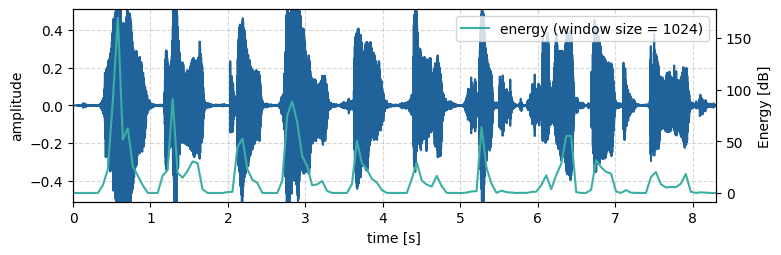

In [6]:
# You can choose the optimal window size empirically
win_size = 1024

x, sr = torchaudio.load('recording_16kHz.wav')
x = x[0].numpy()

energies_db = []
for i in range(len(x) // win_size + 1):
    x_win = x[i * win_size: (i + 1) * win_size]

    # calculate energy of signal fragment
    energies_db.append(sum(x_win * x_win))

energies_db = np.array(energies_db)

plot_signal_energies(x, sr, energies_db, win_size)

### Partitioning the Audio (3 point)

Now that you can see when you need a digit and when you don't, I hope you will have no trouble coming up with **a heuristic** for finding the boundaries of spoken words. You will then use this heuristic to parition your audio sequences into individual digits.

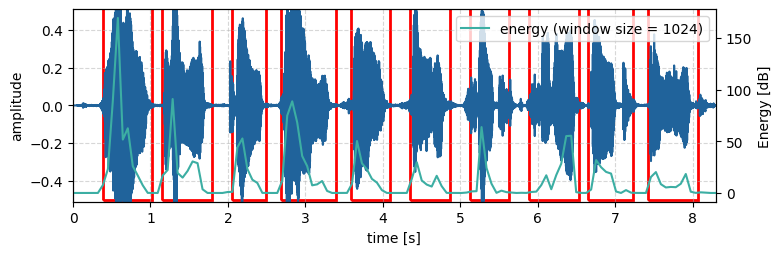

In [7]:
# list of digit intervals [(a_0, b_0), ...]
# where a_i -- first audio sample of spoken word, b_i -- last sample

threshold = 0.9
intervals = []
is_spoken_interval = False


for i in range(len(x) // win_size + 1):
    energy = energies_db[i]
    start_interval = i * win_size
    end_interval = (i + 1) * win_size
    if energy < threshold:
        if is_spoken_interval == False:
            continue
        else:
            intervals[-1].append(end_interval)
            is_spoken_interval = False
    else:
        if is_spoken_interval == False:
            intervals.append([start_interval])
            is_spoken_interval = True
        else:
            continue

for interval_1, interval_2 in zip(intervals[-2::-1], intervals[-1:0:-1]):
    start_1, end_1 = interval_1
    start_2, end_2 = interval_2

    if end_1 == start_2:
        interval_1[1] = end_2
        intervals.remove(interval_2)

# Visualize where your boundaries are
plot_signal_energies(x, sr, energies_db, win_size, intervals)

We will split the original record into fragments and save them to the directory with the dataset.

In [8]:
test_directory = 'AudioMNIST/data/test'
if not os.path.exists(test_directory):
    os.mkdir(test_directory)

n = 0
for a, b in intervals:
    x_digit = x[a: b]
    path = f'{test_directory}/{n % 10}_test_{n // 10}.wav'
    print(f'"{DIGIT_NAMES[n % 10]}" -> {path}')
    n += 1

    torchaudio.save(path, torch.FloatTensor(x_digit).unsqueeze(0), sr, channels_first=True)
    display(Audio(path))

"zero" -> AudioMNIST/data/test/0_test_0.wav


"one" -> AudioMNIST/data/test/1_test_0.wav


"two" -> AudioMNIST/data/test/2_test_0.wav


"three" -> AudioMNIST/data/test/3_test_0.wav


"four" -> AudioMNIST/data/test/4_test_0.wav


"five" -> AudioMNIST/data/test/5_test_0.wav


"six" -> AudioMNIST/data/test/6_test_0.wav


"seven" -> AudioMNIST/data/test/7_test_0.wav


"eight" -> AudioMNIST/data/test/8_test_0.wav


"nine" -> AudioMNIST/data/test/9_test_0.wav


# Data Processing Pipeline (5 point)

In this part you will implement the dataloading, preprocessing and batching utilities necessary to train and test your model.


### Grading criteria - for **ASSESSORS**

```
[ ] (2 points) - Data preprocessing - do the features look sensible?
[ ] (3 points) - Batching
```

### Dataloader

The class below (a subclass of `torch.utils.data.Dataset`) holds the logic of loading `AudioMNIST` dataset. All the file handling routines are already written

I added the filepaths to the list of item information so that I could identify the types of audio samples on which my model was failing. However, this approach didn't provide significant insight. While I noticed that the model struggled with some very fast and very slow samples, the majority of incorrect predictions occurred on what I considered to be typical samples.

In [9]:
class AudioMNISTDataset(data.Dataset):
    def __init__(self, directory: str, mode='train'):
        self.mode = mode
        assert mode == 'train' or mode == 'valid' or mode == 'test'
        self.filepaths = []
        self.labels = []
        for filepath in sorted(glob(os.path.join(directory, '*', '?_*_*.wav'))):
            digit, speaker, example_id = os.path.basename(filepath).replace('.wav', '').split('_')
            add = False
            if speaker == 'test' and mode == 'test':
                add = True
            if speaker != 'test' and int(speaker) % 6 == 0 and mode == 'valid':
                add = True
            if speaker != 'test' and int(speaker) % 6 != 0 and mode == 'train':
                add = True
            if add:
                self.filepaths.append(filepath)
                self.labels.append(int(digit))

        print(f"Dataset [{mode}]: {len(self.filepaths)} audios")

    def __getitem__(self, idx) -> Tuple[torch.FloatTensor, torch.LongTensor]:
        x, sr = torchaudio.load(self.filepaths[idx])
        y = torch.LongTensor([self.labels[idx]])[0]

        # Conversion to correct sample rate...

        effects = [
            ['gain', '-n', '0'],        # apply 10 db attenuation
            ['remix', '-'],             # merge all the channels
            ['rate', '16000']
        ]
        x, sr = torchaudio.sox_effects.apply_effects_tensor(x, sr, effects)

        # x: audio features
        # y: target digit class
        return x[0], y, self.filepaths[idx]

    def __len__(self):
        return len(self.filepaths)

train_dataset = AudioMNISTDataset('AudioMNIST/data', mode='train')
valid_dataset = AudioMNISTDataset('AudioMNIST/data', mode='valid')
test_dataset = AudioMNISTDataset('AudioMNIST/data', mode='test')

Dataset [train]: 25000 audios
Dataset [valid]: 5000 audios
Dataset [test]: 10 audios


#### Choosing a Representation  (2 point)

You could use the waveform itself as an audio representation (features), **but** as you know from the lecture (*DSP Basics*), this is not the best representation for many tasks. You may find it useful to look up the following transforms:

`torchaudio.transforms.Spectrogram`

`torchaudio.transforms.MelSpectrogram`

`torchaudio.transforms.AmplitudeToDB`

`torchaudio.transforms.MFCC`

You will be able to return to this stage many times while doing you homework, so iterate from simple representations to sophisticated ones.

In [1]:
train_audio_transforms_spec = nn.Sequential(
    torchaudio.transforms.Spectrogram(
        n_fft=400,
        win_length=400,
        hop_length=160,
        power=0.5
    )
)

train_audio_transforms_mfcc = nn.Sequential(
    torchaudio.transforms.MFCC(
        sample_rate=16000,
        n_mfcc=128,  # was 80, but the quality was worse
        melkwargs={
            'n_fft': 400,
            'n_mels': 128,
            'hop_length': 160,
            'f_min': 0,
            'f_max': 12000
        }
    ),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=10),
    torchaudio.transforms.TimeMasking(time_mask_param=10)
)

train_audio_transforms_a2db = nn.Sequential(
    # Add feature transformations here
    torchaudio.transforms.Spectrogram(
        n_fft=400,
        win_length=400,
        hop_length=160,
        power=0.5
    ),
    torchaudio.transforms.AmplitudeToDB()
)

train_audio_transforms_melspec = nn.Sequential(
    #Add features transformations here
    torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,
        n_fft=400,
        win_length=400,
        hop_length=160,
        n_mels=128,
        f_min=0,
        f_max=8000,
        power=0.5
    ),
    # torchaudio.transforms.TimeStretch(hop_length=160, n_freq=128, fixed_rate=True), - complex values needed
    torchaudio.transforms.FrequencyMasking(freq_mask_param=10),
    torchaudio.transforms.TimeMasking(time_mask_param=10),
)

It's interesting to see what we got...

You may see some interesting points in your audio representation, and **may want to try a different representation**. 🕵️‍ Or return to this later.

In [11]:
max_len_melspec = 0
lls = []

for i, dataset in enumerate([train_dataset, test_dataset, valid_dataset]):
    lls.append([])
    for au in dataset:
        l = train_audio_transforms_spec(au[0]).shape[1]
        lls[i].append(l)
        if l > max_len_melspec:
            max_len_melspec = l

print(max_len_melspec)

100


Despite the maximum length being 100, it's evident that there aren't many samples exceeding a length of 90.

<Axes: ylabel='Count'>

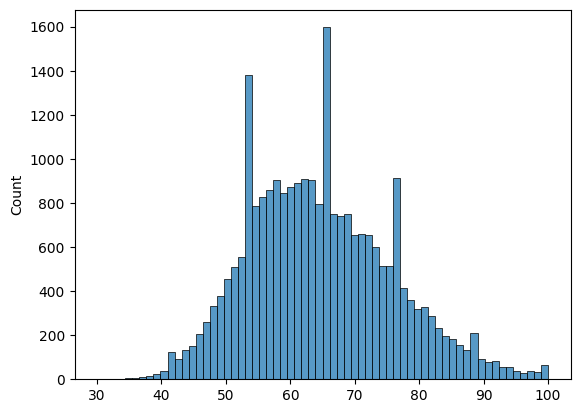

In [23]:
import seaborn as sns
sns.histplot(lls[0])

<Axes: ylabel='Count'>

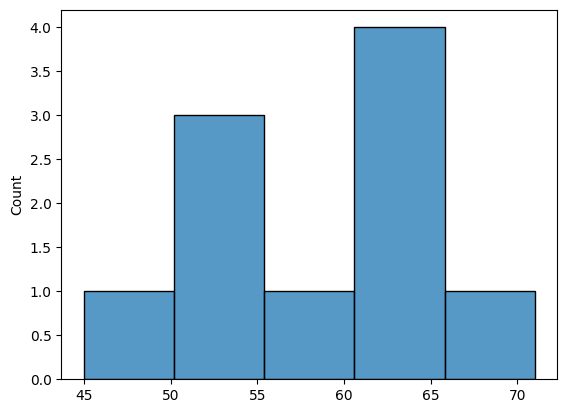

In [24]:
sns.histplot(lls[1])

<Axes: ylabel='Count'>

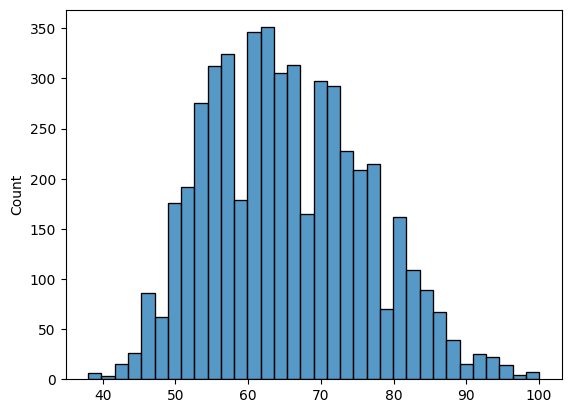

In [25]:
sns.histplot(lls[2])

visualize dataset for training
Spec


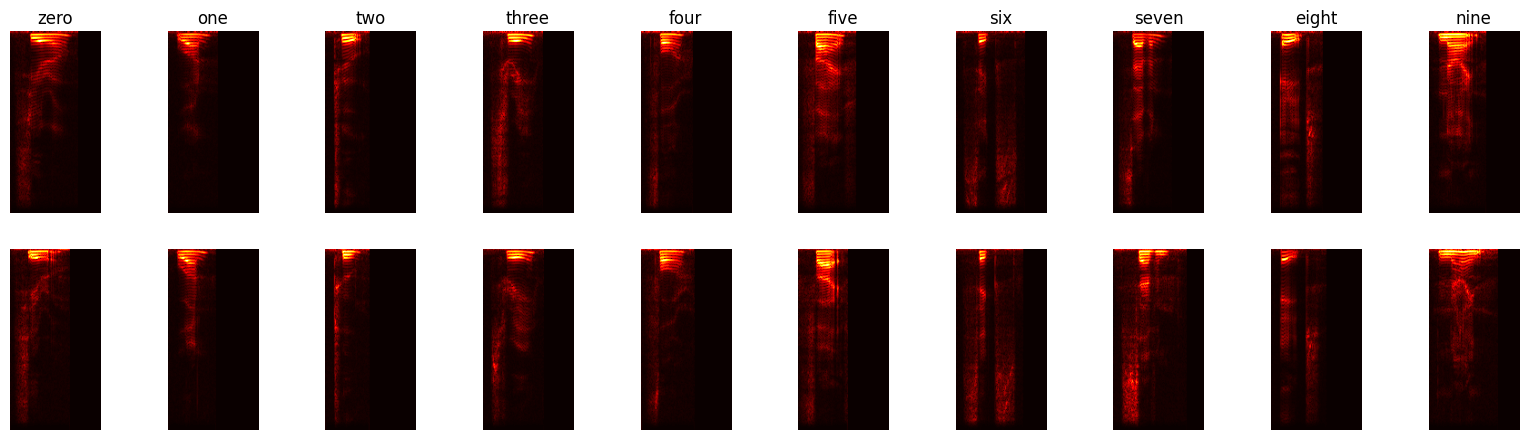

Spectrogram to DB


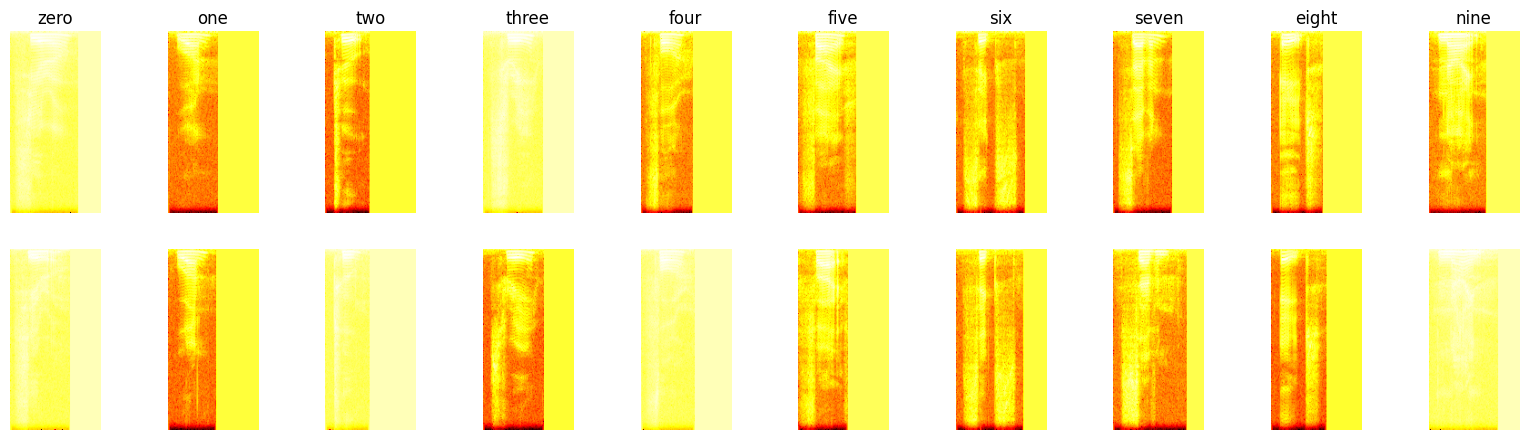

Mel spec


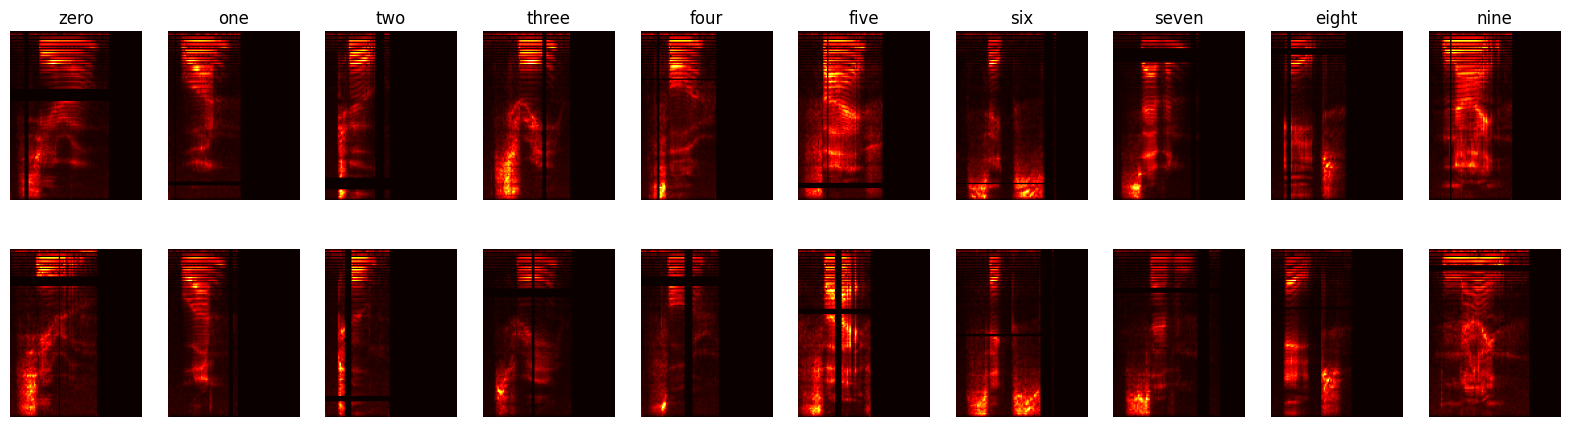

MFCC


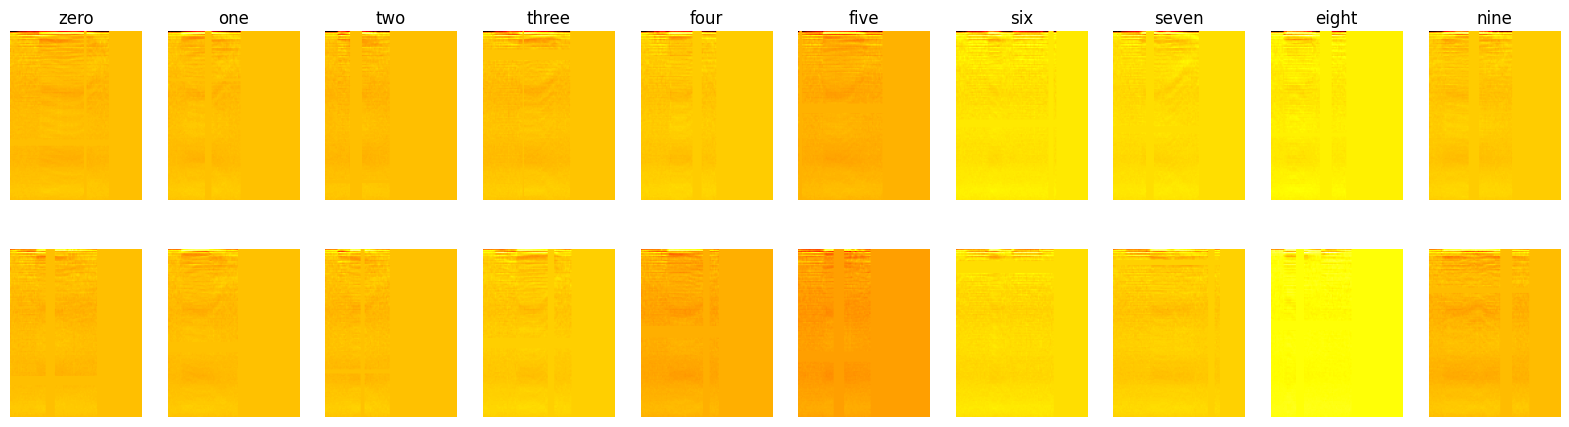

visualize dataset for validation
Spec


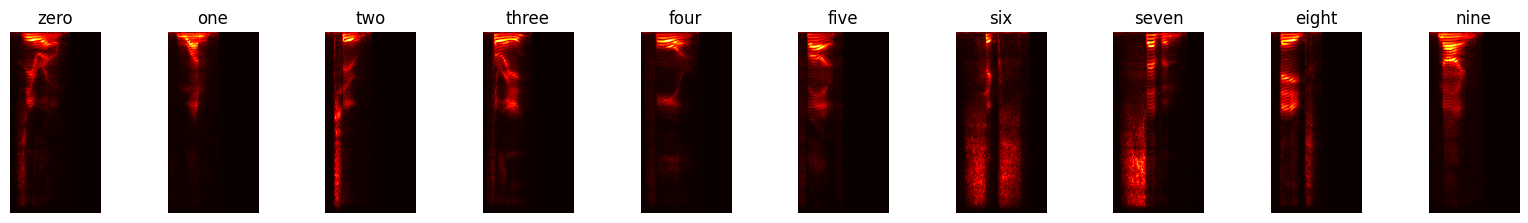

Spectrogram to DB


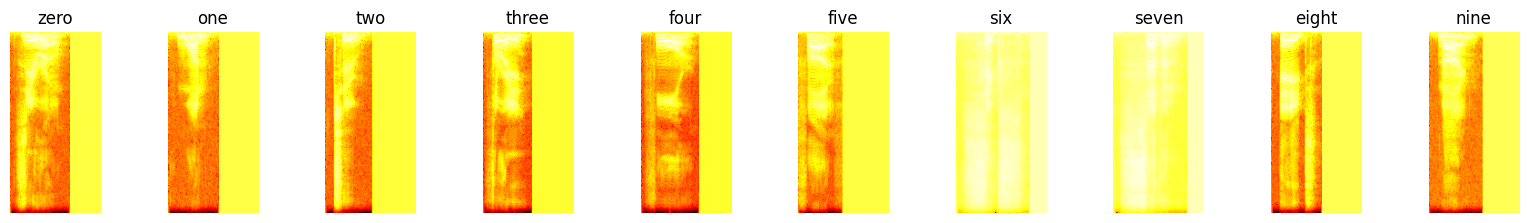

Mel spec


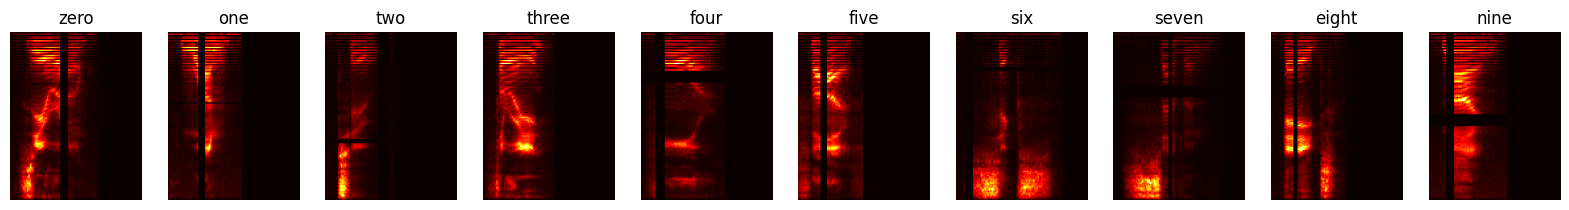

MFCC


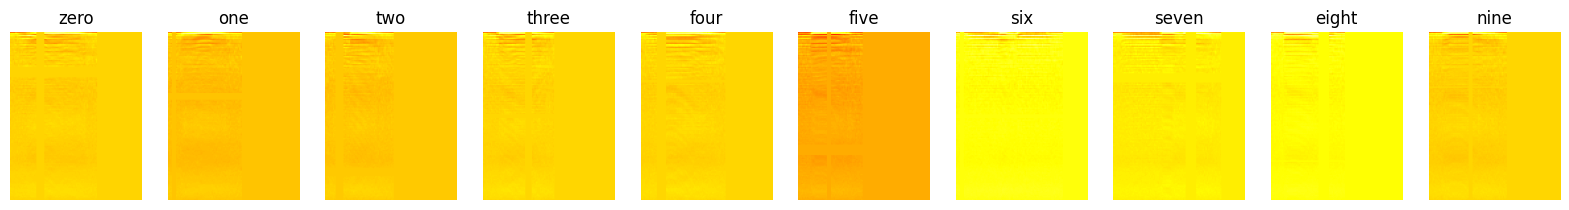

visualize dataset for testing
Spec


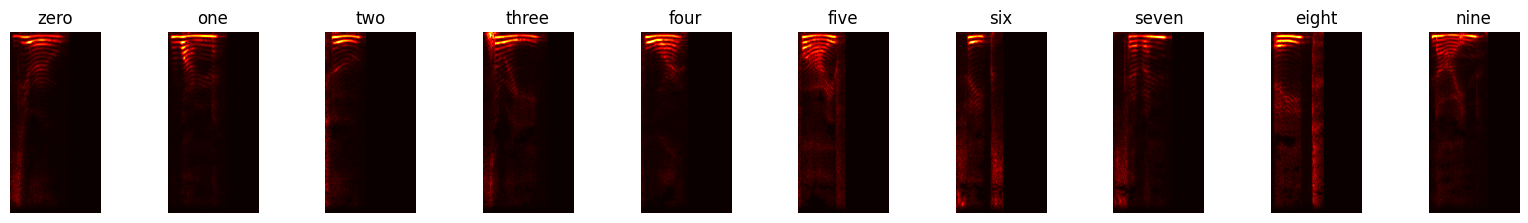

Spectrogram to DB


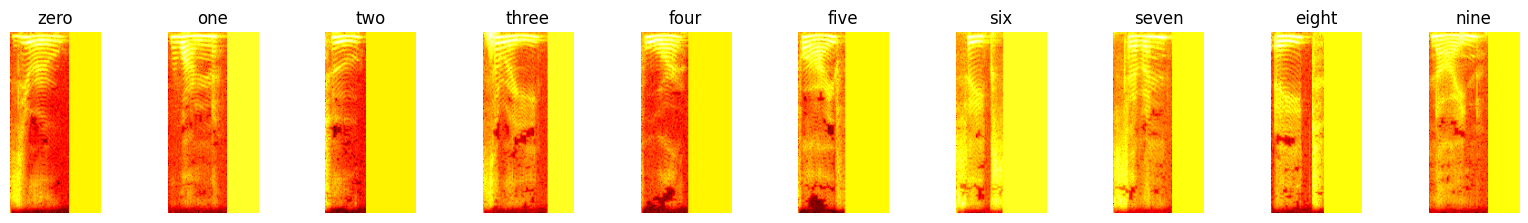

Mel spec


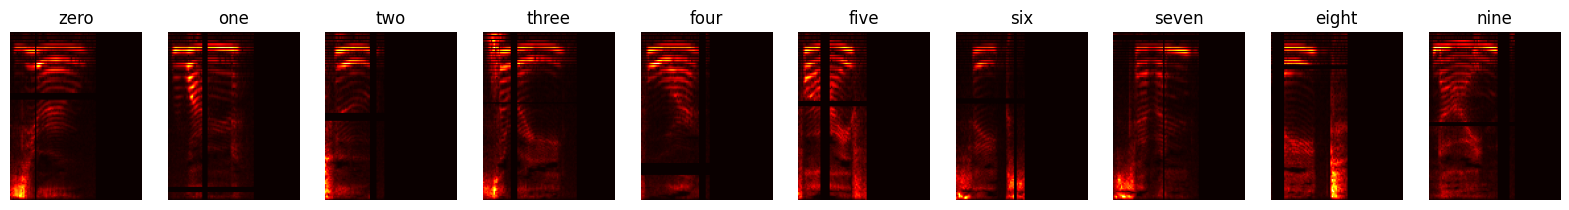

MFCC


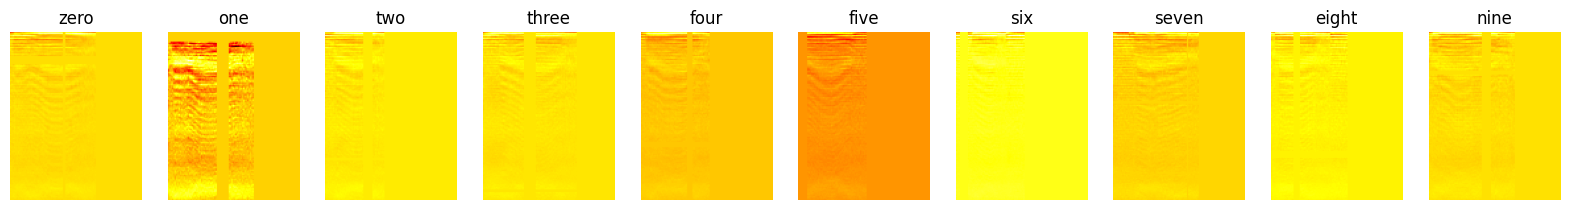

In [12]:
def show_some_examples_by_representation(dataset, K, name, train_audio_transforms_func,
                                         figsize=(18, 8), max_length=100):
    print(name)
    fig = plt.figure(figsize=figsize)
    for digit in range(10):
        indices = np.where(np.array(dataset.labels) == digit)[0]
        for i in range(K):
            x, y, _ = dataset[indices[i]]
            x = train_audio_transforms_func(x)
            # to show the sample as it is while training
            pad_length = max_length - x.shape[-1]
            x = F.pad(x, (0, pad_length), value=0)
            ax = fig.add_subplot(3, 10, digit + i * 10 + 1)
            #rotate
            if i == 0:
                ax.set_title(DIGIT_NAMES[digit])
            ax.imshow(x, cmap="hot")
            ax.axis('off')
    plt.show()

def show_some_examples(dataset, K, figsize=(18, 8), max_length=100):
    # Spectrogram
    show_some_examples_by_representation(dataset, K, "Spec", train_audio_transforms_spec,
                                         figsize=(20, 8), max_length=100)
    # Spectrogram + to DB
    show_some_examples_by_representation(dataset, K, "Spectrogram to DB", train_audio_transforms_a2db,
                                         figsize=(20, 8), max_length=100)
    # Mel spectrogram
    show_some_examples_by_representation(dataset, K, "Mel spec", train_audio_transforms_melspec,
                                         figsize=(20, 8), max_length=100)
    # MFCC
    show_some_examples_by_representation(dataset, K, "MFCC", train_audio_transforms_mfcc,
                                         figsize=(20, 8), max_length=100)


print("visualize dataset for training")
show_some_examples(train_dataset, 2)

print("visualize dataset for validation")
show_some_examples(valid_dataset, 1)

print("visualize dataset for testing")
show_some_examples(test_dataset, 1)

The main goal of classification is to make examples from the same class as similar as possible and examples from different classes as different as possible. This contrast is more pronounced when using features like MFCC and Mel spectrograms compared to using simple spectrograms or spectrograms with amplitude-to-decibel conversion. I tried run the models both with MFCC and Mel spectrograms, and the results for melspec were slightly better.

In [13]:
test_audio_transforms_melspec = nn.Sequential(
    #Add feature transformations here
    torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,
        n_fft=400,
        win_length=400,
        hop_length=160,
        n_mels=128,
        f_min=0,
        f_max=8000,
        power=0.5
    )
)

test_audio_transforms_mfcc = nn.Sequential(
    torchaudio.transforms.MFCC(
        sample_rate=16000,
        n_mfcc=128,
        melkwargs={
            'n_fft': 400,
            'n_mels': 128,
            'hop_length': 160,
            'f_min': 0,
            'f_max': 12000
        }
    )
)


Can you determine **which number is pronounced** looking at it? If so, then the computer can!

Notice that the audio has different durations because words have different numbers of phonemes and people speak at different speed. Thus, our feature tensors do not have a fixed size either!

```
- Can we bring them to the same size?
- Yes, we can. And it will even work (see the dataset article).
- So why don't we do that?
- This approach has a limited scope. And here's why:
```

* First, in real ASR systems, we do not classify words, but *sounds* (graphemes, phonemes) – they are more difficult to localize and difficult to classify independently. Although, for example, for the task of classifying the sounds of birdsong, this approach would be normal.
* Secondly, convolutional neural networks (actually for which we would like images of the same size) poorly orient in space, since they react to patterns, and may not pay attention to their spatial location. In our problem, the words are quite unique, so they are uniquely identified by a set of sounds (phonemes), so this approach would work. But we're taking a course in **speech recognition and synthesis, not sound classification**. 🙂

### Batch generation class (3 points)
All DL frameworks work with tensors (not lists of tensors). You need to somehow concatenate the individual audio samples into a batch, so that they are processed efficiently. The difficulty is that audio samples have varying length. We suggest you try zero padding, but don't forget to store original length.


Opted to shorten each sample by 5 frames at the beginning and by 10 frames at the end, as there is not much information in those sections, and there are few samples with a length greater than 90 frames.

In [14]:
# from torch.nn.utils.rnn import pad_sequence
class Collate:
    def __init__(self, train_audio_transforms_func, test_audio_transforms_func, train=False) -> None:
        super(Collate, self).__init__()

        self.train = train
        self.train_audio_transforms_func = train_audio_transforms_func
        self.test_audio_transforms_func = test_audio_transforms_func

    def __call__(self, batch: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, ... ] :
        """
        :param batch: is a list of tuples of [features, label], where features has dimensions [n_features, length]
        "returns features, lengths, labels:
              features is a Tensor [batchsize, features, max_length]
              lengths is a Tensor of lengths [batchsize]
              labels is a Tesnor of targets [batchsize]
        """

        batch_features = []
        batch_filepaths = []
        batch_labels = torch.LongTensor(len(batch)).zero_()
        batch_lengths = torch.LongTensor(len(batch)).zero_()
        max_length = 90

        i = 0
        for features, label, filepath in batch:
            batch_labels[i] = label
            if self.train:
                features = self.train_audio_transforms_func(features)
            else:
                features = self.test_audio_transforms_func(features)
            pad_length = max_length - features.shape[-1]
            if pad_length < 1:
                batch_features.append(features[:, 5:max_length])
                batch_lengths[i] = max_length
            else:
                batch_lengths[i] = features.shape[-1]
                batch_features.append(F.pad(features, (0, pad_length), value=0)[:, 5:max_length])
            batch_filepaths.append(filepath)
            i += 1

        batch_features = torch.stack(batch_features, dim=0)

        return batch_features, batch_lengths, batch_labels, batch_filepaths

In [15]:
train_collate_fn = Collate(train_audio_transforms_melspec, test_audio_transforms_melspec, train=True)
test_collate_fn = Collate(train_audio_transforms_melspec, test_audio_transforms_melspec, train=False)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1, drop_last=True, collate_fn=train_collate_fn)
valid_loader = data.DataLoader(valid_dataset, batch_size=32, shuffle=False,num_workers=1, collate_fn=test_collate_fn)
test_loader =  data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=1, collate_fn=test_collate_fn)

xs, ls, ys, _ = next(iter(train_loader))
print(xs.size(), ls.size(), ys.size())
print(xs.dtype, ls.dtype, ys.dtype)

# Assessment


assert xs.dtype == torch.float32
assert ys.dtype == torch.int64
assert ls.dtype == torch.int64

assert len(xs.size()) == 3
assert xs.size()[0] == ls.size()[0] and ls.size()[0]  == ys.size()[0]

torch.Size([32, 128, 85]) torch.Size([32]) torch.Size([32])
torch.float32 torch.int64 torch.int64


# Implementing and training your Digit Classifier


### Grading criteria - for **ASSESSORS**

```
[ ] (6 points) Train classification model (> 95% accuracy on validation)
      [ ] (1 point)  > 55% Accuracy
      [ ] (2 points) > 60% Accuracy
      [ ] (3 points) > 65% Accuracy
      [ ] (4 point)  > 75% Accuracy
      [ ] (5 points) > 85% Accuracy
      [ ] (6 points) > 95% Accuracy
[ ] (6 points) Achieve good test-score on our side (> 85% accuracy on hidden sample)
      [ ] (1 point)  > 55% Accuracy
      [ ] (2 points) > 60% Accuracy
      [ ] (3 points) > 65% Accuracy
      [ ] (4 point)  > 75% Accuracy
      [ ] (5 points) > 85% Accuracy
      [ ] (6 points) > 95% Accuracy
```

## The neural network classifier

Write a model for classifying audio. It is desirable to use convolutional layers near the input to process your features and some kind of recurrent layer, such as GRU/LSTM/BiLSTM near the end for making the classification. Start with a simple model and make it more complicated if necessary.

You can look at some of these papers for inspiration:
* https://arxiv.org/pdf/1904.03288.pdf

## Training, validation, testing 🏋 ️

The minimally sufficient code for training and testing is already written. But feel free to modify the code (but try not to break the compatibility).

**Tips**:
* before you start long-term training, see how your model behaves on the first iterations/epochs
* it is desirable that the training epoch takes less one minute; if longer, maybe your model is too complex
* models converge quickly, so it hardly makes sense to do training more than 100 epochs

After experimenting with two models - the first and the last Convolutional layers from the paper [https://arxiv.org/pdf/1904.03288.pdf], and the entire architecture as outlined in the same paper - I observed a slight difference in performance, albeit noticeable. Despite the small discrepancy, I opted to use the larger architecture for its potential benefits. After experimenting with both BatchNorm and LayerNorm, I found that BatchNorm performed better on the test dataset, while LayerNorm outperformed on the validation dataset. Given the assumption that the validation dataset is more diverse, I ultimately opted for LayerNorm.

In [16]:
class Model(nn.Module):
    def __init__(self, in_channels=128, repeat_subblocks=4, n_classes=10):
        super(Model, self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv1d(in_channels, 256, kernel_size=11, stride=2, padding=5),
            nn.LayerNorm(43),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        blocks_1 = []
        for _ in range(repeat_subblocks - 1):
            blocks_1.append(nn.Sequential(
                nn.Conv1d(256, 256, kernel_size=11, padding=5),
                nn.LayerNorm(43),
                nn.ReLU(),
                nn.Dropout(0.2)
            ))
        blocks_1.append(nn.Sequential(
                nn.Conv1d(256, 256, kernel_size=11, padding=5),
                nn.LayerNorm(43),
            ))
        self.block_1 = nn.Sequential(*blocks_1)

        self.residual_1 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=11, padding=5),
            nn.LayerNorm(43),
            )

        self.dropout_block_1 = nn.Dropout(0.2)

        blocks_2 = []
        for _ in range(repeat_subblocks - 1):
            blocks_2.append(nn.Sequential(
                nn.Conv1d(256, 256, kernel_size=13, padding=6),
                nn.LayerNorm(43),
                nn.ReLU(),
                nn.Dropout(0.2)
            ))
        blocks_2.append(nn.Sequential(
                nn.Conv1d(256, 384, kernel_size=13, padding=6),
                nn.LayerNorm(43)
            ))
        self.block_2 = nn.Sequential(*blocks_2)

        self.residual_2 = nn.Sequential(
            nn.Conv1d(256, 384, kernel_size=13, padding=6),
            nn.LayerNorm(43),
            )

        self.dropout_block_2 = nn.Dropout(0.2)

        blocks_3 = []
        for _ in range(repeat_subblocks - 1):
            blocks_3.append(nn.Sequential(
                nn.Conv1d(384, 384, kernel_size=17, padding=8),
                nn.LayerNorm(43),
                nn.ReLU(),
                nn.Dropout(0.2)
            ))
        blocks_3.append(nn.Sequential(
                nn.Conv1d(384, 512, kernel_size=17, padding=8),
                nn.LayerNorm(43),
            ))
        self.block_3 = nn.Sequential(*blocks_3)

        self.residual_3 = nn.Sequential(
            nn.Conv1d(384, 512, kernel_size=17, padding=8),
            nn.LayerNorm(43),
            )

        self.dropout_block_3 = nn.Dropout(0.2)

        blocks_4 = []
        for _ in range(repeat_subblocks - 1):
            blocks_4.append(nn.Sequential(
                nn.Conv1d(512, 512, kernel_size=21, padding=10),
                nn.LayerNorm(43),
                nn.ReLU(),
                nn.Dropout(0.2)
            ))
        blocks_4.append(nn.Sequential(
                nn.Conv1d(512, 640, kernel_size=21, padding=10),
                nn.LayerNorm(43),
            ))
        self.block_4 = nn.Sequential(*blocks_4)

        self.residual_4 = nn.Sequential(
            nn.Conv1d(512, 640, kernel_size=21, padding=10),
            nn.LayerNorm(43),
            )

        self.dropout_block_4 = nn.Dropout(0.3)

        blocks_5 = []
        for _ in range(repeat_subblocks - 1):
            blocks_5.append(nn.Sequential(
                nn.Conv1d(640, 640, kernel_size=25, padding=12),
                nn.LayerNorm(43),
                nn.ReLU(),
                nn.Dropout(0.2)
            ))
        blocks_5.append(nn.Sequential(
                nn.Conv1d(640, 768, kernel_size=25, padding=12),
                nn.LayerNorm(43),
            ))
        self.block_5 = nn.Sequential(*blocks_5)

        self.residual_5 = nn.Sequential(
            nn.Conv1d(640, 768, kernel_size=25, padding=12),
            nn.LayerNorm(43),
            )

        self.dropout_block_5 = nn.Dropout(0.3)

        self.conv_2 = nn.Sequential(
            nn.Conv1d(768, 896, kernel_size=29, dilation=2, padding=14),
            nn.LayerNorm(15),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.conv_3 = nn.Sequential(
            nn.Conv1d(896, 1024, kernel_size=1),
            nn.LayerNorm(15),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        self.conv_4 = nn.Sequential(
            nn.Conv1d(1024, n_classes, kernel_size=1),
            nn.Flatten(),
            nn.Linear(150, 10)
        )

        self.relu = nn.ReLU()


    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        x = self.conv_1(x)
        x_block = self.block_1(x)
        x_res = self.residual_1(x)
        x = self.dropout_block_1(self.relu(x_block + x_res))
        x_block = self.block_2(x)
        x_res = self.residual_2(x)
        x = self.dropout_block_2(self.relu(x_block + x_res))
        x_block = self.block_3(x)
        x_res = self.residual_3(x)
        x = self.dropout_block_3(self.relu(x_block + x_res))
        x_block = self.block_4(x)
        x_res = self.residual_4(x)
        x = self.dropout_block_4(self.relu(x_block + x_res))
        x_block = self.block_5(x)
        x_res = self.residual_5(x)
        x = self.dropout_block_5(self.relu(x_block + x_res))
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        return x


def create_model_and_optimizer(device):
    model = Model().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    return model, optimizer

In [ ]:
# My previous architecture

# class Model(nn.Module):
#     def __init__(self, in_channels=128, repeat_subblocks=2, n_classes=10):
#         super(Model, self).__init__()
#         self.conv_1 = nn.Sequential(
#             nn.Conv1d(in_channels, 256, kernel_size=11, padding=5),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.2)
#         )
#         self.conv_4 = nn.Sequential(
#             nn.Conv1d(256, n_classes, kernel_size=1),
#             nn.Flatten(),
#             nn.Linear(1000, 10)
#         )


#     def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
#         x = self.conv_1(x)
#         x = self.conv_4(x)
#         return x


# def create_model_and_optimizer(device):
#     model = Model().to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
#     return model, optimizer

### Training and Evaluation Functions

In [17]:
# Training and evaluation function
def train(model, optimizer, loader, metrics):
    model.train()

    losses = []
    for x, lengths, y, _ in loader:
        x, y = x.to(device), y.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        y_pred = model(x, lengths)
        loss = F.cross_entropy(y_pred, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    metrics['train_loss'].append(np.mean(losses))


def evaluate(model, loader, metrics, mode):
    model.eval()

    losses = []
    cm = np.zeros((10, 10), dtype=np.int32)
    with torch.no_grad():
        valid_losses = []
        for x, lengths, y, filepaths in loader:
            x, y = x.to(device), y.to(device)
            lengths = lengths.to(device)

            y_pred = model(x, lengths)
            loss = F.cross_entropy(y_pred, y)
            losses.append(loss.item())
            if mode == 'test':
                print(nn.Softmax(y_pred))
            y_pred = y_pred.argmax(axis=-1)
            for i in range(len(x)):
                cm[y[i].item(), y_pred[i].item()] += 1
                # if y[i].item() != y_pred[i].item():
                #     print(f"True Label: {y[i].item()}, Predicted Label: {y_pred[i].item()}")
                #     display(Audio(filepaths[i]))


    metrics[f'{mode}_loss'].append(np.mean(losses))
    metrics[f'{mode}_accuracy'].append(np.trace(cm) / np.sum(cm))
    metrics[f'{mode}_confusion'].append(cm)


def train_from_scratch(model, optimizer, train_loader, valid_loader, test_loader):
    metrics = {
        'train_loss': [],
        'valid_loss': [],
        'valid_accuracy': [],
        'valid_confusion': [],
        'test_loss': [],
        'test_accuracy': [],
        'test_confusion': []
    }

    best_valid_accuracy = 0.0
    for epoch in tqdm(range(20)):
        train(model, optimizer, train_loader, metrics)

        evaluate(model, valid_loader, metrics, 'valid')
        evaluate(model, test_loader, metrics, 'test')

        if metrics['valid_accuracy'][-1] > best_valid_accuracy:
            best_valid_accuracy = metrics['valid_accuracy'][-1]
            torch.save({
                'state_dict': model.state_dict(),
                'metrics': metrics
            }, checkpoint_path)

    return metrics

### Main Training and Evaluation Loop

I also printet out the logits for the test dataset. After examining them, I noticed that all models consistently misclassified the 4th class as the 1st class. Despite attempts, I haven't yet found a solution to rectify this misclassification.

In [18]:
# Training Loop
torch.manual_seed(0)# torch.set_deterministic(True)
torch.use_deterministic_algorithms(True)  # https://discuss.pytorch.org/t/use-deterministic-algorithms/118600 + updated the environment variable CUBLAS_WORKSPACE_CONFIG at the beginning of the notebook

np.random.seed(0)

checkpoint_path = 'model.pth'
model, optimizer = create_model_and_optimizer(device)

if os.path.exists(checkpoint_path):
    print(f'Loading model weights from {checkpoint_path}')
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt['state_dict'])
    metrics = ckpt['metrics']
    evaluate(model, valid_loader, metrics, 'valid')
    evaluate(model, test_loader, metrics, 'test')
else:
    print('Training model from scratch..')
    metrics = train_from_scratch(model, optimizer, train_loader, valid_loader, test_loader)

Training model from scratch..


Softmax(
  dim=tensor([[ 7.5880, -0.5847,  2.0496, -0.9622,  5.5873, -2.5926, -3.4390,  5.0173,
           -3.6068, -2.7119],
          [-5.6932,  7.4006, -6.3440, -2.0022, -0.4015,  3.5211, -1.2163,  0.6457,
           -3.2909,  9.1234],
          [ 2.7807, -5.6933,  7.7139,  3.3614,  4.0916, -0.2879, -3.5941, -0.8888,
            0.8691, -4.9454],
          [-4.7699, -1.4240, -1.8263,  5.6110, -1.4849,  5.4630,  1.1137, -1.8414,
           -0.3009,  0.2151],
          [-0.9173,  8.2775, -2.8371, -0.8599,  6.6766,  3.2940, -5.2360,  0.6875,
           -4.1269,  3.9602],
          [-6.2041, -0.0543, -4.3734,  1.5929, -3.8981,  4.8475,  3.6348, -2.8743,
            1.7841,  1.7353],
          [-0.2095, -7.8030,  2.0145,  2.8063, -2.9354, -1.7144,  6.5166, -2.5005,
            2.5831, -5.2135],
          [-2.4353, -3.9926, -0.5832,  3.6312, -2.7564,  0.9928,  1.1621,  5.3155,
           -4.8967, -0.8115],
          [-0.6284, -4.3736,  1.4755,  2.6002, -3.6785, -1.2631,  2.6939, -4.0766,


I thougt maybe there are some problems with the data, like wrong labels. But the labels are okay.

### Visualization of the results

We will select the model based on the best accuracy value during validation. Let's evaluate the accuracy of the model on the test set.

In [19]:
# Visualization helper function
def plot_accuracies(valid_accuracy, test_accuracy, best_epoch):
    best_valid = valid_accuracy[best_epoch]
    best_test = test_accuracy[best_epoch]

    plt.figure(figsize=(7, 3))
    plt.title('Accuracy')
    plt.plot(valid_accuracy, label='valid', color='#20639b')
    plt.plot(test_accuracy, label='test', color='#3caea3')
    plt.grid(linestyle='--', alpha=0.5)
    plt.vlines(best_epoch, 0.6, 1, color='#ed553b', linestyle='--', label='best')
    plt.hlines(best_valid, 0, best_epoch, linestyle='--', color='#555555')
    plt.hlines(best_test, 0, best_epoch, linestyle='--', color='#555555')
    plt.plot(best_epoch, best_valid, marker='o', color='#20639b')
    plt.plot(best_epoch, best_test, marker='o', color='#3caea3')
    plt.text(0, best_valid - 0.02, f"{best_valid:.4f}")
    plt.text(0, best_test - 0.02, f"{best_test:.4f}")
    plt.ylim(0.8, 1.01)
    plt.xlim(0, len(valid_accuracy) - 1)
    plt.xticks(range(len(valid_accuracy)))
    plt.yticks(np.linspace(0.8, 1.0, 11))
    plt.legend()
    plt.show()


def plot_confusion_matrix(cm, names, title='Confusion matrix', normalize=False):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)

    if names is not None:
        tick_marks = np.arange(len(names))
        plt.xticks(tick_marks, names, rotation=45)
        plt.yticks(tick_marks, names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            kwargs = {
                'color': "white" if cm[i, j] > thresh else "black",
                'horizontalalignment': 'center'
            }
            if normalize:
                plt.text(j, i, "{:0.2f}".format(cm[i, j]), **kwargs)
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]), **kwargs)

    accuracy = np.trace(cm) / float(np.sum(cm))

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel(f'Predicted label\naccuracy={accuracy:0.4f}')
    plt.show()

With LayerNorm

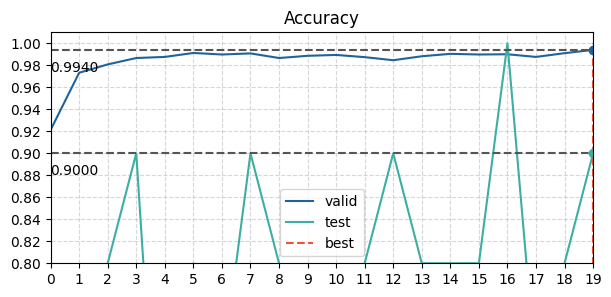

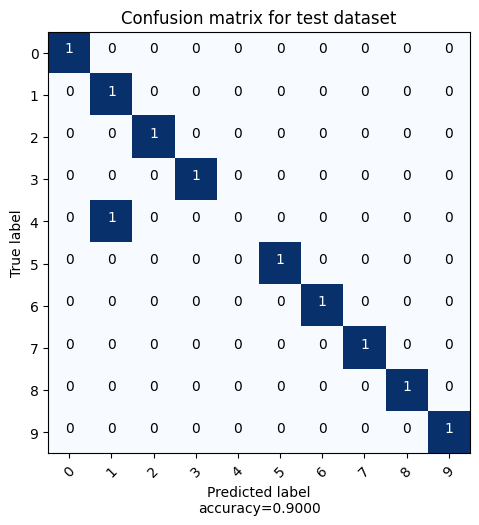

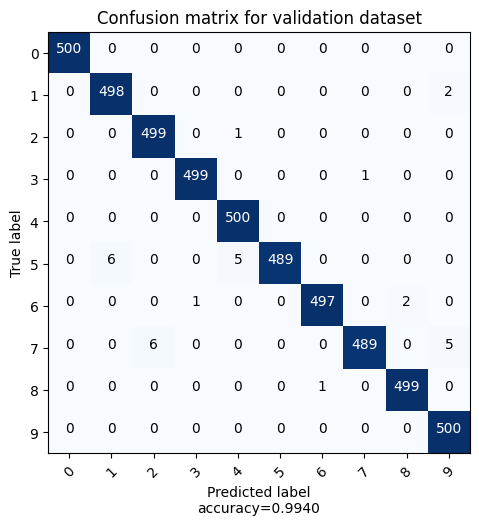

In [20]:
# choosing model by best accuracy on validation set
best = np.argmax(metrics['valid_accuracy'])
best_cm = metrics['test_confusion'][best]

plot_accuracies(metrics['valid_accuracy'], metrics['test_accuracy'], best)
plot_confusion_matrix(best_cm, range(10), title='Confusion matrix for test dataset')
plot_confusion_matrix(metrics['valid_confusion'][best], range(10), title='Confusion matrix for validation dataset')

With BatchNorm

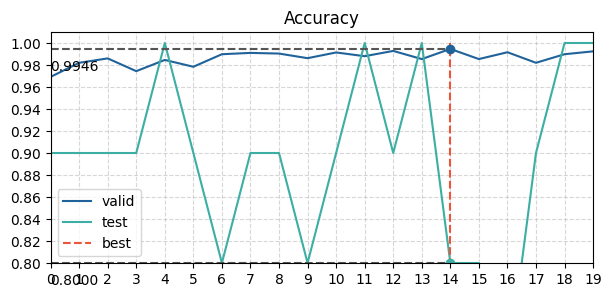

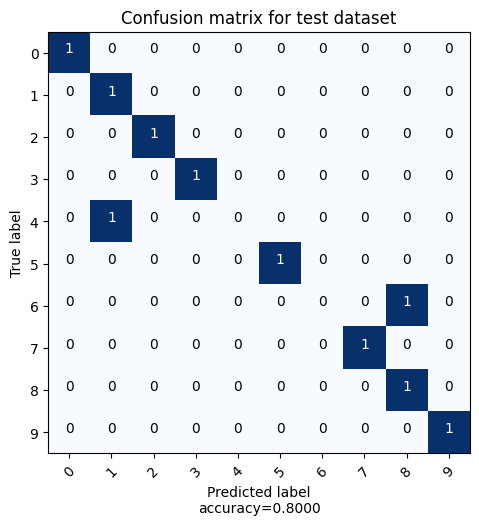

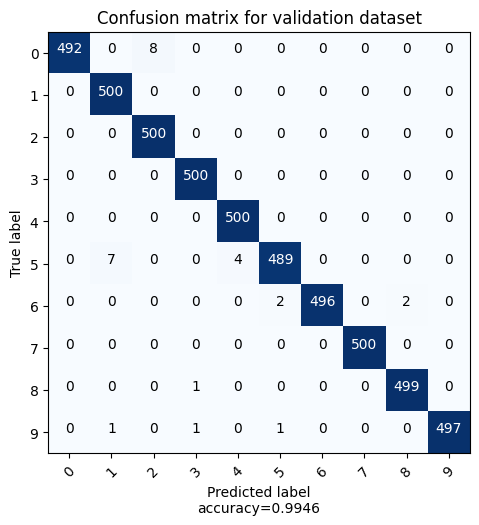

In [28]:
# choosing model by best accuracy on validation set
best = np.argmax(metrics['valid_accuracy'])
best_cm = metrics['test_confusion'][best]

plot_accuracies(metrics['valid_accuracy'], metrics['test_accuracy'], best)
plot_confusion_matrix(best_cm, range(10), title='Confusion matrix for test dataset')
plot_confusion_matrix(metrics['valid_confusion'][best], range(10), title='Confusion matrix for validation dataset')

### Regularization and Augmentation

In order to improve the quality of your model, you may want to play around with different regularization and augmentation techniques. Some things to try could be:

* Dropout (used)
* L2 regularization
* BatchNorm / LayerNorm (used)
* Different learning rate schedules

Augmentations are applied to training data to improve the generalization ability of the deep neural model. Think about what augmentations you can apply to the audio, and then check how they work by experiment. You can look at some data augmentation techniques here:

* [SpecAugment](https://arxiv.org/abs/1904.08779)

For this you may find the following functions useful:

`torchaudio.transforms.FrequencyMasking` (used)

`torchaudio.transforms.TimeMasking` (used)

`torchaudio.transforms.TimeStretch`

In [ ]:
# run experiments here, reuse previously defined functions

# Questions and Conclusions (4 points) 🧑‍🎓

1. Which audio representation did you choose and why?
2. Justify your choice of neural network architecture.
3. Did you use any data augmentation? Justify your choice of augmentation.
4. What did you like in this homework, and what didn't?


1. [ ] I chose to use Mel spectrograms as the audio representation for this classification task. The primary objective of classification is to ensure that examples from the same class are as similar as possible, while examples from different classes are as dissimilar as possible. Mel spectrograms, along with MFCCs, provide a more pronounced contrast between classes compared to simple spectrograms or spectrograms with amplitude-to-decibel conversion. After experimenting with both MFCCs and Mel spectrograms, I found that the results for Mel spectrograms were slightly better. Therefore, I decided to use Mel spectrograms as they better capture the relevant features for the classification task at hand.
2. [ ] After experimenting with two models - the first and the last Convolutional layers from the paper [https://arxiv.org/pdf/1904.03288.pdf], and the entire architecture as outlined in the same paper - I observed a slight difference in performance, albeit noticeable. Despite the small discrepancy, I opted to use the larger architecture for its potential benefits. Additionally, I conducted experiments with both BatchNorm and LayerNorm and found that BatchNorm performed better on the test dataset, while LayerNorm outperformed on the validation dataset. Given the assumption that the validation dataset is more diverse, I ultimately opted for LayerNorm. Although my chosen model architecture is complex and has a longer training time, taking approximately 3.5 minutes per epoch, I decided to retain this solution as it closely aligns with the architecture outlined in the recommended paper.
3. [ ] I implemented frequency and time masking as data augmentation techniques in my project. Although I initially explored the possibility of using timestretch augmentation, I encountered warnings indicating that it is better suited for complex data. Consequently, I decided against its usage. However, I believe that timestretch augmentation could potentially be beneficial and worth exploring further in future iterations. Additionally, I considered incorporating pitch and noise augmentation techniques, particularly if I had chosen to use the usual spectrogram representation. While I did not implement these techniques in the current iteration, I recognize their potential usefulness and may explore them in future experiments.
4. [ ] I particularly enjoyed the opportunity to work with a fresh dataset, although I noted that the dataset's paper was published in late 2023. Being able to utilize my own data to evaluate the results was also a valuable aspect of the assignment. During the process, I found it insightful to explore heuristics for dividing audio into different samples. This experience led me to realize the importance of recording audio with sufficient pauses between words (and thank God my laziness spared me from the effort of recording a better test sample, and I focused my energy on finding effective heuristics). Additionally, it sparked my curiosity about the challenges involved in segmenting words in real speech. Implementing the architecture from the provided paper and experimenting with improvement propositions listed in the task instructions were also highlights of the assignment. Maybe there were also some things that weren't good about this homework, but I can't remember them.
